[*********************100%%**********************]  1 of 1 completed
0
1
2
3
4
5
6
7
8
9
[135.05148296 135.33975069 135.63174339 135.92746436 136.22691632
 136.53010142 136.83702121 137.14767661 137.46206788 137.7801946
 138.10205563 138.42764912 138.75697245 139.09002218 139.42679409
 139.76728308 140.11148317 140.45938747 140.81098813 141.16627634
 141.52524223 141.88787492 142.25416242 142.6240916  142.99764819
 143.3748167  143.75558039 144.13992124 144.5278199  144.91925564
 145.31420632 145.71264833 146.11455657 146.51990436 146.92866343
 147.34080385 147.75629398 148.17510045 148.59718806 149.02251974
 149.45105652 149.88275745 150.31757956 150.75547779 151.19640492
 151.64031154 152.08714596 152.53685418 152.9893798  153.44466395
 153.90264526 154.36325975 154.82644082 155.29211912 155.76022253
 156.23067605 156.70340176 157.17831876 157.65534306 158.13438752
 158.61536179 159.09817224 159.58272188 160.06891025 160.55663343
 161.04578386 161.53625036 162.027918   162.52066803 1

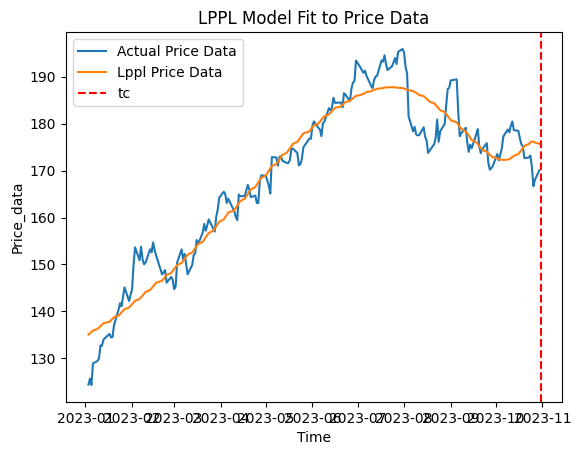

In [12]:
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


def lppl(t, A, B, C, tc, beta, omega, phi):
    return np.exp(A + (B * (tc - t) ** beta) * (1+C * (np.cos(omega * np.log1p(tc - t) + phi)))).ravel()


def E(b1, A1, A, B, C, tc, beta, omega, phi):
    diff_1 = lppl(A1, A, B, C, tc, beta, omega, phi) - b1
    lppl_result = np.mean(diff_1**2)
    return lppl_result

def E_count(b1, A1, A, B, C, tc, beta, omega, phi):
    lppl_res = lppl(A1, A, B, C, tc, beta, omega, phi)
    print(lppl_res)
    diff_1 = lppl_res - b1
    lppl_result = np.mean(diff_1**2)
    return lppl_res,lppl_result


# 下載 APPL 歷史數據
symbol = 'AAPL'
start_date = '2023-01-01'
end_date = '2023-12-31'

data = yf.download(symbol, start=start_date, end=end_date)

# 選擇調整過後的收盤價
price_data = data['Adj Close']

# 將每一個收盤價取對數
log_price_data = np.log(price_data)

A1 = np.arange(0, len(log_price_data)).reshape((len(log_price_data), 1))
b1 = price_data

# 下一個程式部分
p = 10000  # 組群大小
r = 0.01  # 存活率
m = 10  # 突變數量
g = 10  # 演化代數


survive = round(p*r)  # 存活個體數目

pop = np.random.randint(0, 2, (p, 40))  # 初代，隨機的二進位基因族群,fu
fit = np.zeros((p, 1))

for generation in range(g):
    print(generation)
    # 將每個基因的適配度放入fit
    for pp in range(p):
        gene = pop[pp, :]  # 第p個基因
        # tc的數字範圍在[204,215]
        tc = (np.sum(2**np.array(range(10)) * gene[:10]) - 511) % 12 + 204
        # beta的數字範圍在[0,1]
        beta = (np.sum(2**np.array(range(10))*gene[10:20])-511)/100
        # omega的數字沒有範圍
        omega = (np.sum(2**np.array(range(10))*gene[20:30]) - 511) / 100
        # 將 omega 映射到區間 [0, pi]
        omega = max(0, min(np.pi, omega))
        # phi的數字範圍在[0,2pi]
        phi = (np.sum(2**np.array(range(10)) * gene[30:40]) - 511) / 100
        # 將 phi 映射到區間 [0, 2pi]
        phi = max(0, min(2 * np.pi, phi))

        # F1的程式碼
        n = tc
        b1 = price_data[:n]
        A1 = np.arange(0, n).reshape((n, 1))
        b2 = np.zeros((n, 1))
        A2 = np.zeros((n, 3))  # 開A1二維陣列

        for i in range(n):
            b2[i] = log_price_data[i]
            A2[i, 0] = 1
            A2[i, 1] = (tc-i)**beta
            A2[i, 2] = ((tc-i)**beta) * np.cos(omega * np.log(tc - i) + phi)

        x = np.linalg.lstsq(A2, b2, rcond=None)[0]

        A = x[0]
        B = x[1]
        C = x[2] / B
        fit[pp] = E(b1, A1, A, B, C, tc, beta, omega, phi)
        # print(pp)

    # print("順序")
    sortf = np.argsort(fit[:, 0])  # 將裡面的數字由小到大的index獲取
    pop = pop[sortf, :]  # 使pop依照這個順序排列

    # 交配
    # print("交配")
    for i in range(survive, p):  # 從survive ~ p的基因死亡，產生孩子放回去
        # print("交配 : ", i)
        # 在前面還活者的選擇
        fid = np.random.randint(0, survive)  # 選擇父親
        mid = np.random.randint(0, survive)  # 選擇母親
        while mid == fid:  # 兩者要不同
            # print("hihi")
            mid = np.random.randint(0, survive)

        mask = np.random.randint(0, 2, (1, 40))
        son = pop[mid, :].copy()
        father = pop[fid, :]
        son[mask[0, :] == 1] = father[mask[0, :] == 1]  # 將子代mask為1的位置換成另一個父代的基因
        pop[i, :] = son

    # 突變
    # print("突變")
    for i in range(m):
        mr = np.random.randint(survive, p)
        mc = np.random.randint(0, 40)
        pop[mr, mc] = 1-pop[mr, mc]


# 計算十代之後留下的基因，計算各個基因的適配度
for i in range(p):
    gene = pop[i, :]
    tc = (np.sum(2**np.array(range(10)) * gene[:10]) - 511) % 12 + 204
    beta = (np.sum(2**np.array(range(10))*gene[10:20])-511)/100
    omega = (np.sum(2**np.array(range(10))*gene[20:30]) - 511) / 100
    omega = max(0, min(np.pi, omega))
    phi = (np.sum(2**np.array(range(10)) * gene[30:40]) - 511) / 100
    phi = max(0, min(2 * np.pi, phi))
    fit[i] = E(b1, A1, A, B, C, tc, beta, omega, phi)

sortf = np.argsort(fit[:, 0])
pop = pop[sortf, :]

gene = pop[0, :]  # 找到fit最低就是最好的
tc = (np.sum(2**np.array(range(10)) * gene[:10]) - 511) % 12 + 204
beta = (np.sum(2**np.array(range(10))*gene[10:20])-511)/100
omega = (np.sum(2**np.array(range(10))*gene[20:30]) - 511) / 100
omega = max(0, min(np.pi, omega))
phi = (np.sum(2**np.array(range(10)) * gene[30:40]) - 511) / 100
phi = max(0, min(2 * np.pi, phi))

n = tc
b1 = price_data[:n]
A1 = np.arange(0, n).reshape((n, 1))
b2 = np.zeros((n, 1))
A2 = np.zeros((n, 3))  # 開A1二維陣列
for i in range(n):
    b2[i] = log_price_data[i]
    A2[i, 0] = 1
    A2[i, 1] = (tc-i)**beta
    A2[i, 2] = ((tc-i)**beta) * np.cos(omega * np.log(tc - i) + phi)

x = np.linalg.lstsq(A2, b2, rcond=None)[0]

A = x[0]
B = x[1]
C = x[2] / B

LPPL_final ,fitness_MES = E_count(b1, A1, A, B, C, tc, beta, omega, phi)

print('tc:', tc, ' beta:', beta, ' omega:', omega, ' phi:', phi)
print('A:', A, ' B:', B, ' C:', C)
print("MES : ",fitness_MES)

tc_index = int(tc)
price_data_fit = price_data[:tc_index]

plt.plot(price_data_fit.index, price_data_fit, label='Actual Price Data')
plt.plot(price_data_fit.index, LPPL_final, label='Lppl Price Data')
plt.axvline(x=price_data.index[tc], color='red', linestyle='--', label='tc')

plt.title('LPPL Model Fit to Price Data')
plt.xlabel('Time')
plt.ylabel('Price_data')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed
0
1
2
3
4
5
6
7
8
9


C:\Users\USER\AppData\Local\Temp\ipykernel_7460\3141865696.py:8: RuntimeWarning: invalid value encountered in power
  return np.exp(A + (B * (tc - t) ** beta) * (1+C * (np.cos(omega * np.log1p(tc - t) + phi)))).ravel()
C:\Users\USER\AppData\Local\Temp\ipykernel_7460\3141865696.py:8: RuntimeWarning: divide by zero encountered in log1p
  return np.exp(A + (B * (tc - t) ** beta) * (1+C * (np.cos(omega * np.log1p(tc - t) + phi)))).ravel()
C:\Users\USER\AppData\Local\Temp\ipykernel_7460\3141865696.py:8: RuntimeWarning: invalid value encountered in log1p
  return np.exp(A + (B * (tc - t) ** beta) * (1+C * (np.cos(omega * np.log1p(tc - t) + phi)))).ravel()
C:\Users\USER\AppData\Local\Temp\ipykernel_7460\3141865696.py:8: RuntimeWarning: invalid value encountered in cos
  return np.exp(A + (B * (tc - t) ** beta) * (1+C * (np.cos(omega * np.log1p(tc - t) + phi)))).ravel()
C:\Users\USER\AppData\Local\Temp\ipykernel_7460\3141865696.py:8: RuntimeWarning: overflow encountered in exp
  return np.exp(

[133.851054   134.19938879 134.55052698 134.90446567 135.26120133
 135.62072987 135.98304658 136.34814612 136.7160225  137.08666904
 137.46007839 137.83624247 138.21515245 138.59679877 138.98117106
 139.36825815 139.75804804 140.15052786 140.54568388 140.94350143
 141.34396494 141.74705785 142.15276262 142.56106068 142.97193244
 143.38535721 143.80131319 144.21977745 144.6407259  145.06413322
 145.48997288 145.91821707 146.3488367  146.7818013  147.21707908
 147.6546368  148.0944398  148.53645193 148.98063552 149.42695135
 149.87535859 150.32581479 150.7782758  151.23269578 151.6890271
 152.14722036 152.60722429 153.06898573 153.5324496  153.99755884
 154.46425437 154.93247502 155.40215753 155.87323647 156.34564418
 156.81931078 157.29416404 157.77012942 158.24712994 158.72508619
 159.20391623 159.6835356  160.16385721 160.64479132 161.1262455
 161.60812455 162.09033046 162.57276237 163.05531651 163.53788615
 164.02036156 164.50262994 164.98457538 165.46607881 165.94701797
 166.4272673

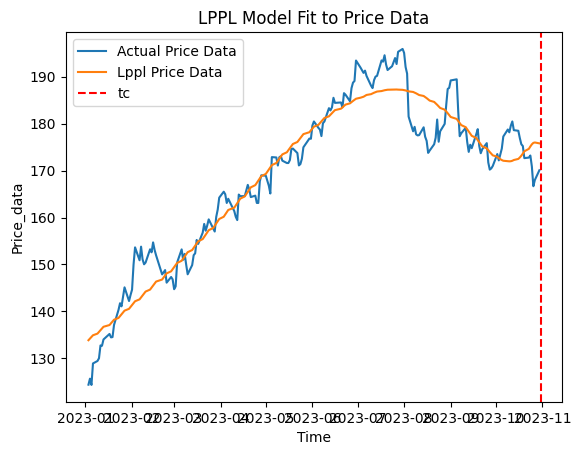

In [13]:
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


def lppl(t, A, B, C, tc, beta, omega, phi):
    return np.exp(A + (B * (tc - t) ** beta) * (1+C * (np.cos(omega * np.log1p(tc - t) + phi)))).ravel()


def E(b1, A1, A, B, C, tc, beta, omega, phi):
    diff_1 = lppl(A1, A, B, C, tc, beta, omega, phi) - b1
    lppl_result = np.mean(diff_1**2)
    return lppl_result

def E_count(b1, A1, A, B, C, tc, beta, omega, phi):
    lppl_res = lppl(A1, A, B, C, tc, beta, omega, phi)
    print(lppl_res)
    diff_1 = lppl_res - b1
    lppl_result = np.mean(diff_1**2)
    return lppl_res,lppl_result


# 下載 APPL 歷史數據
symbol = 'AAPL'
start_date = '2023-01-01'
end_date = '2023-12-31'

data = yf.download(symbol, start=start_date, end=end_date)

# 選擇調整過後的收盤價
price_data = data['Adj Close']

# 將每一個收盤價取對數
log_price_data = np.log(price_data)

A1 = np.arange(0, len(log_price_data)).reshape((len(log_price_data), 1))
b1 = price_data

# 下一個程式部分
p = 10000  # 組群大小
r = 0.01  # 存活率
m = 10  # 突變數量
g = 10  # 演化代數


survive = round(p*r)  # 存活個體數目

pop = np.random.randint(0, 2, (p, 40))  # 初代，隨機的二進位基因族群,fu
fit = np.zeros((p, 1))

for generation in range(g):
    print(generation)
    # 將每個基因的適配度放入fit
    for pp in range(p):
        gene = pop[pp, :]  # 第p個基因
        # tc的數字範圍在[204,215]
        tc = (np.sum(2**np.array(range(10)) * gene[:10]) - 511) % 12 + 204
        # beta的數字範圍在[0,1]
        beta = (np.sum(2**np.array(range(10))*gene[10:20])-511)/100
        # omega的數字沒有範圍
        omega = (np.sum(2**np.array(range(10))*gene[20:30]))

        # phi的數字範圍在[0,2pi]
        phi = (np.sum(2**np.array(range(10)) * gene[30:40]) - 511) / 100
        # 將 phi 映射到區間 [0, 2pi]
        phi = max(0, min(2 * np.pi, phi))

        # F1的程式碼
        n = tc
        b1 = price_data[:n]
        A1 = np.arange(0, n).reshape((n, 1))
        b2 = np.zeros((n, 1))
        A2 = np.zeros((n, 3))  # 開A1二維陣列

        for i in range(n):
            b2[i] = log_price_data[i]
            A2[i, 0] = 1
            A2[i, 1] = (tc-i)**beta
            A2[i, 2] = ((tc-i)**beta) * np.cos(omega * np.log(tc - i) + phi)

        x = np.linalg.lstsq(A2, b2, rcond=None)[0]

        A = x[0]
        B = x[1]
        C = x[2] / B
        fit[pp] = E(b1, A1, A, B, C, tc, beta, omega, phi)
        # print(pp)

    # print("順序")
    sortf = np.argsort(fit[:, 0])  # 將裡面的數字由小到大的index獲取
    pop = pop[sortf, :]  # 使pop依照這個順序排列

    # 交配
    # print("交配")
    for i in range(survive, p):  # 從survive ~ p的基因死亡，產生孩子放回去
        # print("交配 : ", i)
        # 在前面還活者的選擇
        fid = np.random.randint(0, survive)  # 選擇父親
        mid = np.random.randint(0, survive)  # 選擇母親
        while mid == fid:  # 兩者要不同
            # print("hihi")
            mid = np.random.randint(0, survive)

        mask = np.random.randint(0, 2, (1, 40))
        son = pop[mid, :].copy()
        father = pop[fid, :]
        son[mask[0, :] == 1] = father[mask[0, :] == 1]  # 將子代mask為1的位置換成另一個父代的基因
        pop[i, :] = son

    # 突變
    # print("突變")
    for i in range(m):
        mr = np.random.randint(survive, p)
        mc = np.random.randint(0, 40)
        pop[mr, mc] = 1-pop[mr, mc]


# 計算十代之後留下的基因，計算各個基因的適配度
for i in range(p):
    gene = pop[i, :]
    tc = (np.sum(2**np.array(range(10)) * gene[:10]) - 511) % 12 + 204
    beta = (np.sum(2**np.array(range(10))*gene[10:20])-511)/100
    omega = (np.sum(2**np.array(range(10))*gene[20:30]))

    phi = (np.sum(2**np.array(range(10)) * gene[30:40]) - 511) / 100
    phi = max(0, min(2 * np.pi, phi))
    fit[i] = E(b1, A1, A, B, C, tc, beta, omega, phi)

sortf = np.argsort(fit[:, 0])
pop = pop[sortf, :]

gene = pop[0, :]  # 找到fit最低就是最好的
tc = (np.sum(2**np.array(range(10)) * gene[:10]) - 511) % 12 + 204
beta = (np.sum(2**np.array(range(10))*gene[10:20])-511)/100
omega = (np.sum(2**np.array(range(10))*gene[20:30]))

phi = (np.sum(2**np.array(range(10)) * gene[30:40]) - 511) / 100
phi = max(0, min(2 * np.pi, phi))

n = tc
b1 = price_data[:n]
A1 = np.arange(0, n).reshape((n, 1))
b2 = np.zeros((n, 1))
A2 = np.zeros((n, 3))  # 開A1二維陣列
for i in range(n):
    b2[i] = log_price_data[i]
    A2[i, 0] = 1
    A2[i, 1] = (tc-i)**beta
    A2[i, 2] = ((tc-i)**beta) * np.cos(omega * np.log(tc - i) + phi)

x = np.linalg.lstsq(A2, b2, rcond=None)[0]

A = x[0]
B = x[1]
C = x[2] / B

LPPL_final ,fitness_MES = E_count(b1, A1, A, B, C, tc, beta, omega, phi)

print('tc:', tc, ' beta:', beta, ' omega:', omega, ' phi:', phi)
print('A:', A, ' B:', B, ' C:', C)
print("MES : ",fitness_MES)

tc_index = int(tc)
price_data_fit = price_data[:tc_index]

plt.plot(price_data_fit.index, price_data_fit, label='Actual Price Data')
plt.plot(price_data_fit.index, LPPL_final, label='Lppl Price Data')
plt.axvline(x=price_data.index[tc], color='red', linestyle='--', label='tc')

plt.title('LPPL Model Fit to Price Data')
plt.xlabel('Time')
plt.ylabel('Price_data')
plt.legend()
plt.show()


In [15]:
print(price_data_fit.index)
print(len(price_data_fit.index))

DatetimeIndex(['2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06',
               '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-17',
               ...
               '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20',
               '2023-10-23', '2023-10-24', '2023-10-25', '2023-10-26',
               '2023-10-27', '2023-10-30'],
              dtype='datetime64[ns]', name='Date', length=208, freq=None)
208


In [23]:
import yfinance as yf

# 下載 APPL 歷史數據
symbol = 'AAPL'
start_date = '2023-01-01'
end_date = '2023-12-31'

data = yf.download(symbol, start=start_date, end=end_date)

# 使用 reset_index 将日期索引转换为列，并为每一天添加一个新的索引值
data_reset_index = data.reset_index()

# 计算每个日期在一年中的天数
data_reset_index['Day'] = data_reset_index['Date'].dt.dayofyear

# 将 'Day' 列设置为新的索引
data_with_day_index = data_reset_index.set_index('Day')

# 選擇調整過後的收盤價，这时 'Day' 就是新的索引
price_data = data_with_day_index['Adj Close']

# 打印前几行结果
print(price_data)


[*********************100%%**********************]  1 of 1 completed
   Day   Adj Close
0    0    0.000000
1    1    0.000000
2    2    0.000000
3    3  124.374802
4    4  125.657639


In [37]:
import yfinance as yf
import numpy as np

# 下載 APPL 歷史數據
symbol = 'AAPL'
start_date = '2023-01-01'
end_date = '2023-12-31'

data = yf.download(symbol, start=start_date, end=end_date)

# 使用 reset_index 将日期索引转换为列，并为每一天添加一个新的索引值
data_reset_index = data.reset_index()



# 计算每个日期在一年中的天数
data_reset_index['Day'] = data_reset_index['Date'].dt.dayofyear

print(len(data_reset_index))

num_day = data_reset_index['Day'][len(data_reset_index)-1]

# 创建一个包含所有天数的新索引
all_days = np.arange(0, num_day +1)


price_data = data_reset_index.set_index('Day').reindex(all_days, fill_value=np.nan)['Adj Close'].reset_index()
price_data['Adj Close'] = np.where(np.isin(price_data['Day'], data_reset_index['Day']), price_data['Adj Close'], 0)

print(price_data.head())


[*********************100%%**********************]  1 of 1 completed
227
   Day   Adj Close
0    0    0.000000
1    1    0.000000
2    2    0.000000
3    3  124.374802
4    4  125.657639


[*********************100%%**********************]  1 of 1 completed
[0.         0.         0.         4.83130766 4.84148769 4.83091101
 4.86676124 0.         0.         4.87081042 4.87522283 4.89595755
 4.89536265 4.90535582 0.         0.         0.         4.91400964
 4.90866495 4.9091053  4.92800462 0.         0.         4.95106672
 4.96100901 4.95633026 4.97092255 4.98442023 0.         0.
 4.96427825 4.97319619 4.98101167 5.01715847 5.04110772 0.
 0.         5.02313437 5.04207178 5.02437751 5.01748758 5.0199247
 0.         0.         5.03843488 5.03422847 5.04794674 5.03753039
 5.0300044  0.         0.         0.         5.00314147 5.00601393
 5.00927715 4.99123019 0.         0.         4.9993881  4.99595769
 4.98170698 4.9857995  5.02005621 0.         0.         5.03830566
 5.0237985  5.03208621 5.01715796 5.00327521 0.         0.
 5.01636601 5.03026487 5.03286571 5.05126752 5.04583369 0.
 0.         5.06110078 5.07289929 5.06381171 5.07071327 5.0789328
 0.         0.         5.06

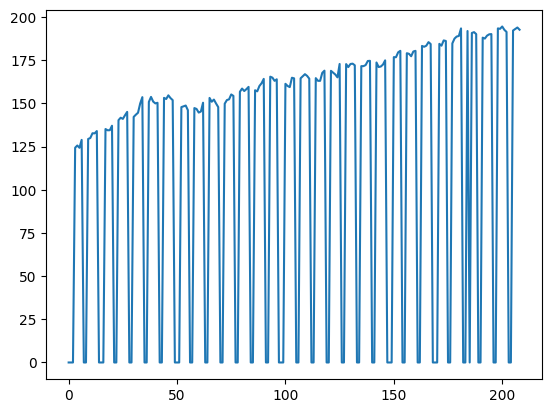

In [59]:
# 下載 APPL 歷史數據
symbol = 'AAPL'
start_date = '2023-01-01'
end_date = '2023-12-31'

data = yf.download(symbol, start=start_date, end=end_date)
data_reset_index = data.reset_index()
data_reset_index['Day'] = data_reset_index['Date'].dt.dayofyear
num_day = data_reset_index['Day'][len(data_reset_index)-1]
all_days = np.arange(0, num_day + 1)

f_price_data = data_reset_index.set_index('Day').reindex(all_days, fill_value=np.nan)[['Adj Close']].reset_index()
f_price_data = f_price_data.fillna(0)

price_data = f_price_data['Adj Close'].values
#print(price_data)

log_price_data = np.log1p(price_data)
print(log_price_data)

tc_index = 209
price_data_fit = price_data[:tc_index]

plt.plot(range(tc_index), price_data_fit, label='Actual Price Data')



In [61]:
# 下載 APPL 歷史數據
symbol = 'AAPL'
start_date = '2023-01-01'
end_date = '2023-12-31'

data = yf.download(symbol, start=start_date, end=end_date)

# 選擇調整過後的收盤價
price_data = data['Adj Close']

print(price_data)

[*********************100%%**********************]  1 of 1 completed
Date
2023-01-03    124.374802
2023-01-04    125.657639
2023-01-05    124.325081
2023-01-06    128.899490
2023-01-09    129.426575
                 ...    
2023-11-20    191.449997
2023-11-21    190.639999
2023-11-22    191.309998
2023-11-24    189.970001
2023-11-27    189.819702
Name: Adj Close, Length: 227, dtype: float64


In [ ]:
# 下載 APPL 歷史數據
symbol = 'AAPL'
start_date = '2023-01-01'
end_date = '2023-12-31'

data = yf.download(symbol, start=start_date, end=end_date)
data_reset_index = data.reset_index()
data_reset_index['Day'] = data_reset_index['Date'].dt.dayofyear
num_day = data_reset_index['Day'][len(data_reset_index)-1]
all_days = np.arange(0, num_day + 1)

f_price_data = data_reset_index.set_index('Day').reindex(all_days, fill_value=np.nan)[['Adj Close']].reset_index()
#f_price_data = f_price_data.fillna(0)

price_data = f_price_data['Adj Close'].values
print(price_data)

tc_index = 209
price_data_fit = price_data[:tc_index]


# 创建掩码，将 NaN 的位置隐藏
mask = ~np.isnan(price_data_fit)

plt.plot(np.arange(tc_index)[mask], price_data_fit[mask], label='Actual Price Data')
plt.xlabel('Day')
plt.ylabel('Adj Close Price')
plt.title('Actual Price Data')
plt.legend()
plt.show()

In [65]:
symbol = 'AAPL'
start_date = '2023-01-01'
end_date = '2023-12-31'

data = yf.download(symbol, start=start_date, end=end_date)
data_reset_index = data.reset_index()
data_reset_index['Day'] = data_reset_index['Date'].dt.dayofyear
num_day = data_reset_index['Day'][len(data_reset_index)-1]
all_days = np.arange(0, num_day + 1)

f_price_data = data_reset_index.set_index('Day').reindex(all_days, fill_value=np.nan)[['Adj Close']].reset_index()
f_price_data_nan = f_price_data
f_price_data = f_price_data.fillna(0)

price_data = f_price_data['Adj Close'].values
price_data_nan = f_price_data_nan['Adj Close'].values

print(price_data)

print("::::")
print(price_data_nan)

# 將每一個收盤價取對數
log_price_data = np.log1p(price_data)

[*********************100%%**********************]  1 of 1 completed
[  0.           0.           0.         124.37480164 125.65763855
 124.3250885  128.89952087   0.           0.         129.42655945
 130.00334167 132.7480011  132.66844177 134.01094055   0.
   0.           0.         135.18437195 134.45845032 134.51811218
 137.10365295   0.           0.         140.32563782 141.73774719
 141.07145691 143.15982056 145.11883545   0.           0.
 142.20513916 143.48796082 144.62161255 149.98167419 153.64122009
   0.           0.         150.8866272  153.79039001 151.07556152
 150.03138733 150.39990234   0.           0.         153.22843933
 152.58105469 154.70245361 153.08900452 151.9336853    0.
   0.           0.         147.88012695 148.30839539 148.79641724
 146.11727905   0.           0.         147.3223877  146.81445312
 144.72293091 145.32051086 150.41981506   0.           0.
 153.20851135 150.98753357 152.25239563 149.9815979  147.90003967
   0.           0.         149.86207581

In [79]:
# 下載 APPL 歷史數據
symbol = 'AAPL'
start_date = '2023-01-01'
end_date = '2023-12-31'

data = yf.download(symbol, start=start_date, end=end_date)
data['Day'] = data.index.dayofyear
data_reset_index = data.set_index('Day')
price_data = data_reset_index['Adj Close']


[*********************100%%**********************]  1 of 1 completed
           Open        High         Low       Close   Adj Close     Volume
Day                                                                       
3    130.279999  130.899994  124.169998  125.070000  124.374794  112117500
4    126.889999  128.660004  125.080002  126.360001  125.657639   89113600
5    127.129997  127.769997  124.760002  125.019997  124.325081   80962700
6    126.010002  130.289993  124.889999  129.619995  128.899506   87754700
9    130.470001  133.410004  129.889999  130.149994  129.426544   70790800
..          ...         ...         ...         ...         ...        ...
324  189.889999  191.910004  189.880005  191.449997  191.449997   46505100
325  191.410004  191.520004  189.740005  190.639999  190.639999   38134500
326  191.490005  192.929993  190.830002  191.309998  191.309998   39617700
328  190.869995  190.899994  189.250000  189.970001  189.970001   24048300
331  189.919998  190.470001  18

In [85]:
# 下載 APPL 歷史數據
symbol = 'AAPL'
start_date = '2023-01-01'
end_date = '2023-12-31'

data = yf.download(symbol, start=start_date, end=end_date)
data['Day'] = data.index.dayofyear
data_reset_index = data.set_index('Day')
price_data = data_reset_index['Adj Close']

# 將每一個收盤價取對數
log_price_data = np.log1p(price_data)


# 将 A1 重塑为与 A2 相同的形状
A1 = price_data.index.to_numpy().reshape(-1, 1)
b1 = price_data

print(A1)

A2 = np.random.random((1000, 1)) * 100


[*********************100%%**********************]  1 of 1 completed
[[  3]
 [  4]
 [  5]
 [  6]
 [  9]
 [ 10]
 [ 11]
 [ 12]
 [ 13]
 [ 17]
 [ 18]
 [ 19]
 [ 20]
 [ 23]
 [ 24]
 [ 25]
 [ 26]
 [ 27]
 [ 30]
 [ 31]
 [ 32]
 [ 33]
 [ 34]
 [ 37]
 [ 38]
 [ 39]
 [ 40]
 [ 41]
 [ 44]
 [ 45]
 [ 46]
 [ 47]
 [ 48]
 [ 52]
 [ 53]
 [ 54]
 [ 55]
 [ 58]
 [ 59]
 [ 60]
 [ 61]
 [ 62]
 [ 65]
 [ 66]
 [ 67]
 [ 68]
 [ 69]
 [ 72]
 [ 73]
 [ 74]
 [ 75]
 [ 76]
 [ 79]
 [ 80]
 [ 81]
 [ 82]
 [ 83]
 [ 86]
 [ 87]
 [ 88]
 [ 89]
 [ 90]
 [ 93]
 [ 94]
 [ 95]
 [ 96]
 [100]
 [101]
 [102]
 [103]
 [104]
 [107]
 [108]
 [109]
 [110]
 [111]
 [114]
 [115]
 [116]
 [117]
 [118]
 [121]
 [122]
 [123]
 [124]
 [125]
 [128]
 [129]
 [130]
 [131]
 [132]
 [135]
 [136]
 [137]
 [138]
 [139]
 [142]
 [143]
 [144]
 [145]
 [146]
 [150]
 [151]
 [152]
 [153]
 [156]
 [157]
 [158]
 [159]
 [160]
 [163]
 [164]
 [165]
 [166]
 [167]
 [171]
 [172]
 [173]
 [174]
 [177]
 [178]
 [179]
 [180]
 [181]
 [184]
 [186]
 [187]
 [188]
 [191]
 [192]
 [193]
 [194]
 [195]


In [115]:

# 下載 APPL 歷史數據
symbol = 'AAPL'
start_date = '2023-01-01'
end_date = '2023-12-31'

data = yf.download(symbol, start=start_date, end=end_date)
data['Day'] = data.index.dayofyear
data_reset_index = data.set_index('Day')
price_data = data_reset_index['Adj Close']

# 將每一個收盤價取對數
log_price_data = np.log1p(price_data)



A1 = price_data.index.to_numpy().reshape(-1, 1)
b1 = price_data

n = tc
b1 = price_data.loc[price_data.index <= n]
A1 = b1.index.to_numpy().reshape(-1, 1)
b2 = np.zeros((n+1, 1))
A2 = np.zeros((n+1, 3))  # 開A1二維陣列

idx_a2 = b1.index

print(idx_a2)
for i in idx_a2:

    print(i)
    b2[i] = log_price_data[i]
    A2[i, 0] = 1
    A2[i, 1] = (tc-i)**beta
    A2[i, 2] = ((tc-i)**beta) * np.cos(omega * np.log1p(tc - i) + phi)

x = np.linalg.lstsq(A2, b2, rcond=None)[0]
A = x[0]
B = x[1]
C = x[2] / B
print('A:', A, ' B:', B, ' C:', C)

[*********************100%%**********************]  1 of 1 completed
Index([  3,   4,   5,   6,   9,  10,  11,  12,  13,  17,
       ...
       195, 198, 199, 200, 201, 202, 205, 206, 207, 208],
      dtype='int32', name='Day', length=142)
3
4
5
6
9
10
11
12
13
17
18
19
20
23
24
25
26
27
30
31
32
33
34
37
38
39
40
41
44
45
46
47
48
52
53
54
55
58
59
60
61
62
65
66
67
68
69
72
73
74
75
76
79
80
81
82
83
86
87
88
89
90
93
94
95
96
100
101
102
103
104
107
108
109
110
111
114
115
116
117
118
121
122
123
124
125
128
129
130
131
132
135
136
137
138
139
142
143
144
145
146
150
151
152
153
156
157
158
159
160
163
164
165
166
167
171
172
173
174
177
178
179
180
181
184
186
187
188
191
192
193
194
195
198
199
200
201
202
205
206
207
208
A: [5.28406868]  B: [-0.00203626]  C: [-0.0824633]


In [48]:
import yfinance as yf
import numpy as np

# 下載 APPL 歷史數據
symbol = 'AAPL'
start_date = '2023-01-01'
end_date = '2023-12-31'

data = yf.download(symbol, start=start_date, end=end_date)

# 使用 reset_index 将日期索引转换为列，并为每一天添加一个新的索引值
data_reset_index = data.reset_index()

# 计算每个日期在一年中的天数
data_reset_index['Day'] = data_reset_index['Date'].dt.dayofyear

num_day = data_reset_index['Day'][len(data_reset_index)-1]

# 创建一个包含所有天数的新索引
all_days = np.arange(0, num_day + 1)

# 创建 price_data DataFrame，使用 'Day' 列作为索引，并只选择 'Adj Close' 列
price_data = data_reset_index.set_index('Day').reindex(all_days, fill_value=np.nan)[['Adj Close']].reset_index()


price_data = price_data.fillna(0)

print(price_data)

adj_close_array = price_data['Adj Close'].values
print(adj_close_array)



[*********************100%%**********************]  1 of 1 completed
     Day   Adj Close
0      0    0.000000
1      1    0.000000
2      2    0.000000
3      3  124.374802
4      4  125.657639
..   ...         ...
327  327    0.000000
328  328  189.970001
329  329    0.000000
330  330    0.000000
331  331  189.389999

[332 rows x 2 columns]
[  0.           0.           0.         124.37480164 125.65763855
 124.3250885  128.89950562   0.           0.         129.42654419
 130.00332642 132.74801636 132.66844177 134.01094055   0.
   0.           0.         135.18437195 134.45845032 134.51811218
 137.10365295   0.           0.         140.32563782 141.73776245
 141.07147217 143.15982056 145.11885071   0.           0.
 142.20513916 143.48794556 144.62162781 149.98168945 153.64122009
   0.           0.         150.88661194 153.79039001 151.07556152
 150.03140259 150.39988708   0.           0.         153.22843933
 152.58105469 154.70245361 153.08900452 151.9336853    0.
   0.           0. 

In [10]:

tc=205
beta= 2.91
omega= 2.18
phi= 4.32
A=5.18454158
B=3.40697827e-08  
C=2.77730214
for t in range(tc):
    print(np.exp(A + (B * (tc - t) ** beta) * np.cos(omega * np.log(tc - t) + phi)).ravel())

[149.45306247]
[149.76857025]
[150.08562044]
[150.40414385]
[150.72407088]
[151.04533154]
[151.36785543]
[151.69157176]
[152.01640938]
[152.34229673]
[152.66916192]
[152.99693267]
[153.32553636]
[153.65490003]
[153.98495041]
[154.31561389]
[154.64681656]
[154.97848423]
[155.31054242]
[155.64291639]
[155.97553115]
[156.30831148]
[156.64118192]
[156.97406685]
[157.30689043]
[157.63957667]
[157.97204943]
[158.30423244]
[158.63604934]
[158.96742367]
[159.2982789]
[159.62853847]
[159.9581258]
[160.28696432]
[160.61497746]
[160.94208875]
[161.26822176]
[161.5933002]
[161.91724788]
[162.23998879]
[162.56144711]
[162.88154723]
[163.20021379]
[163.51737172]
[163.83294624]
[164.14686291]
[164.45904768]
[164.76942689]
[165.07792731]
[165.38447619]
[165.6890013]
[165.99143091]
[166.2916939]
[166.58971975]
[166.88543857]
[167.17878116]
[167.46967905]
[167.75806451]
[168.04387062]
[168.32703127]
[168.60748123]
[168.88515619]
[169.15999277]
[169.43192858]
[169.70090225]
[169.96685349]
[170.2297231]
[